In [1]:
# @title Import Packages
# For running inference on the TensorFlow Hub module.
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image and plotting
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen  # For fetching the image from a URL
from six import BytesIO  # For handling byte data

# For drawing onto the image.
import numpy as np
from PIL import Image  # For image processing
from PIL import ImageColor  # For handling colors
from PIL import ImageDraw  # For drawing on images
from PIL import ImageFont  # For using fonts
from PIL import ImageOps  # For image operations

# For measuring the inference time.
import time

# Print TensorFlow version to verify the installation
print(tf.__version__)

# Check and print available GPU devices to ensure TensorFlow can access them
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())



2.16.1
The following GPU devices are available: 


## Displaying and Resizing Images
The display_image function uses matplotlib to display an image without grid lines, making it suitable for clear visualization in the notebook. The download_and_resize_image function downloads an image from a given URL, resizes it to the specified dimensions, and saves it in JPEG format. It also provides an option to display the resized image using display_image. This function utilizes the PIL library for image processing and saves the image to a temporary file.



In [2]:
def display_image(image):
    # Create a new figure with a specified size of 20x15 inches
    fig = plt.figure(figsize=(20, 15))
    # Turn off the grid lines for the plot
    plt.grid(False)
    # Display the image using matplotlib's imshow function
    plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    # Create a temporary file with a .jpg suffix to store the downloaded image
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    # Open the URL and read the image data from the response
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)  # Convert the image data to a BytesIO object
    
    # Open the image using PIL (Python Imaging Library)
    pil_image = Image.open(image_data)
    
    # Resize and crop the image to fit the specified dimensions (new_width, new_height)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    
    # Convert the image to RGB mode
    pil_image_rgb = pil_image.convert("RGB")
    
    # Save the resized image to the temporary file in JPEG format with a quality of 90
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    # Print the location of the saved image
    print("Image downloaded to %s." % filename)
    
    # If display is True, call the display_image function to show the image
    if display:
        display_image(pil_image)
    
    # Return the filename of the saved image
    return filename


## Image Processing and Visualization Functions
This code includes functions for displaying, downloading, resizing images, and drawing bounding boxes. The display_image function uses matplotlib to show an image. The download_and_resize_image function fetches an image from a URL, resizes it, and saves it locally, with an option to display it. The draw_bounding_box_on_image function adds a bounding box and optional labels to an image, useful for object detection tasks. The draw_boxes function overlays labeled boxes on an image based on provided coordinates, class names, and scores. Finally, an example URL is provided to demonstrate the downloading and resizing of an image.

Image downloaded to C:\Users\Admin\AppData\Local\Temp\tmpf52hs9th.jpg.


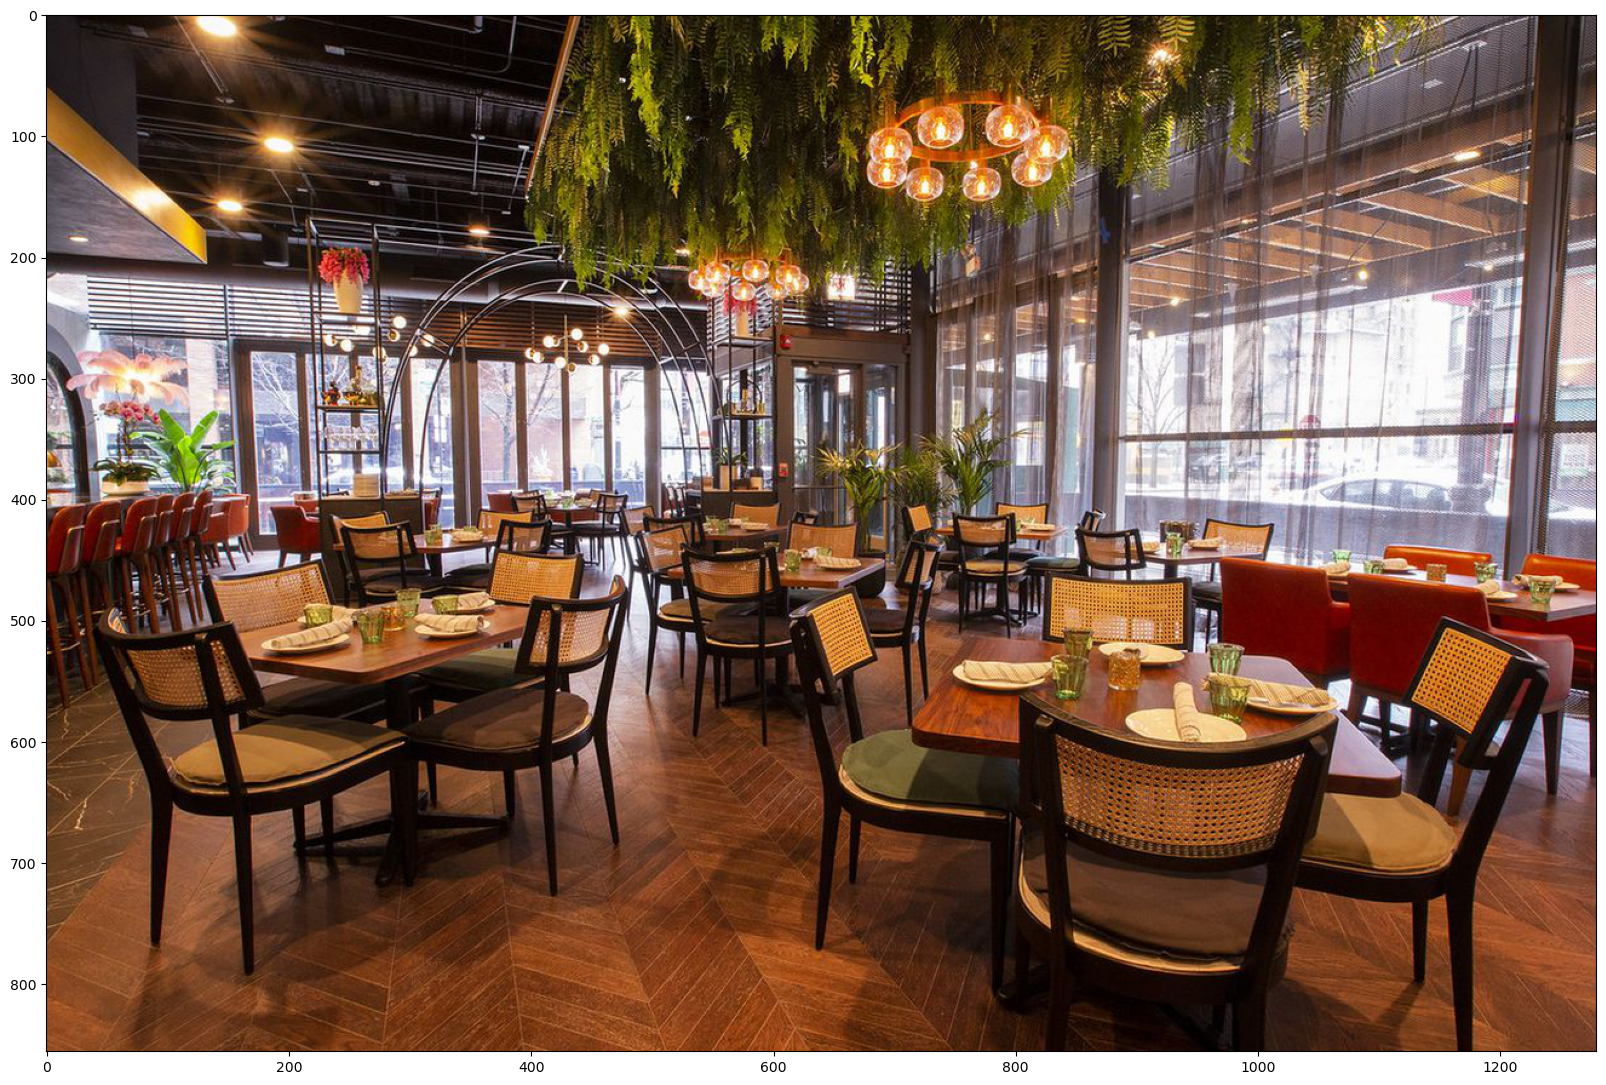

In [4]:
def display_image(image):
    # Create a new figure with a specified size of 20x15 inches
    fig = plt.figure(figsize=(20, 15))
    # Turn off the grid lines for the plot
    plt.grid(False)
    # Display the image using matplotlib's imshow function
    plt.imshow(image)

def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    # Create a temporary file with a .jpg suffix to store the downloaded image
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    # Open the URL and read the image data from the response
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)  # Convert the image data to a BytesIO object
    
    # Open the image using PIL (Python Imaging Library)
    pil_image = Image.open(image_data)
    
    # Resize and crop the image to fit the specified dimensions (new_width, new_height)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ADAPTIVE)
    
    # Convert the image to RGB mode
    pil_image_rgb = pil_image.convert("RGB")
    
    # Save the resized image to the temporary file in JPEG format with a quality of 90
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    # Print the location of the saved image
    print("Image downloaded to %s." % filename)
    
    # If display is True, call the display_image function to show the image
    if display:
        display_image(pil_image)
    
    # Return the filename of the saved image
    return filename

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    # Create a drawing context for the image
    draw = ImageDraw.Draw(image)
    # Get the dimensions of the image
    im_width, im_height = image.size
    # Calculate the coordinates of the bounding box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    
    # Draw the bounding box on the image
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness, fill=color)

    # If the total height of the display strings added to the top of the bounding box
    # exceeds the top of the image, stack the strings below the bounding box instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    # Get a list of colors from the ImageColor module
    colors = list(ImageColor.colormap.values())

    try:
        # Try to load a specific font
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
    except IOError:
        # If the font is not found, use the default font
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    # Loop through each box and draw it on the image if the score is above the minimum score
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

# URL of the image to be downloaded and processed
image_url = "https://cdn.vox-cdn.com/thumbor/5d_RtADj8ncnVqh-afV3mU-XQv0=/0x0:1600x1067/1200x900/filters:focal(672x406:928x662)/cdn.vox-cdn.com/uploads/chorus_image/image/57698831/51951042270_78ea1e8590_h.7.jpg"
# Download, resize, and display the image
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)


## Object Detection Using TensorFlow Hub
This code utilizes a pre-trained object detection model from TensorFlow Hub to identify and draw bounding boxes around objects in an image. The detector is loaded from TensorFlow Hub's Faster R-CNN model. The load_img function reads and decodes an image from a file path. The draw_boxes function overlays bounding boxes and labels on the detected objects within the image. The display_image function uses PIL to display the image. The run_detector function processes an image, runs the detector to identify objects, and displays the image with bounding boxes and labels. The entire process is demonstrated by running the object detector on a sample image.

In [9]:
import tensorflow_hub as hub
import tensorflow as tf
import time
from PIL import Image, ImageDraw, ImageFont

# URL of the TensorFlow Hub module for object detection
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

# Load the object detection module from TensorFlow Hub
detector = hub.load(module_handle).signatures['default']

def load_img(path):
    # Read the image file from the given path
    img = tf.io.read_file(path)
    # Decode the image as a JPEG file and ensure it has 3 color channels (RGB)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    
    for i in range(min(max_boxes, boxes.shape[0])):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = (0, 255, 0)  # RGB green
            
            # Draw bounding box
            im_width, im_height = image.size
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.rectangle([(left, top), (right, bottom)], outline=color, width=2)
            
            # Draw label
            if font:
                text_size = font.getbbox(display_str) if hasattr(font, "getbbox") else font.getsize(display_str)
                text_width, text_height = text_size[2] - text_size[0], text_size[3] - text_size[1]
                draw.rectangle([(left, top - text_height), (left + text_width, top)], fill=color)
                draw.text((left, top - text_height), display_str, fill="black", font=font)
                
    return np.array(image)

def display_image(image):
    image = Image.fromarray(image)
    image.show()

def run_detector(detector, path):
    # Load the image from the specified path
    img = load_img(path)

    # Convert the image to float32 and add a batch dimension
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    # Start the timer to measure inference time
    start_time = time.time()
    # Run the detector on the converted image
    result = detector(converted_img)
    # Stop the timer
    end_time = time.time()

    # Convert the result from tensors to numpy arrays
    result = {key: value.numpy() for key, value in result.items()}

    # Print the number of detected objects and the inference time
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time - start_time)

    # Draw bounding boxes on the image based on the detection results
    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"]
    )

    # Display the image with bounding boxes
    display_image(image_with_boxes)


# Run the object detector on the downloaded image
run_detector(detector, downloaded_image_path)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
Inference time:  28.887612104415894


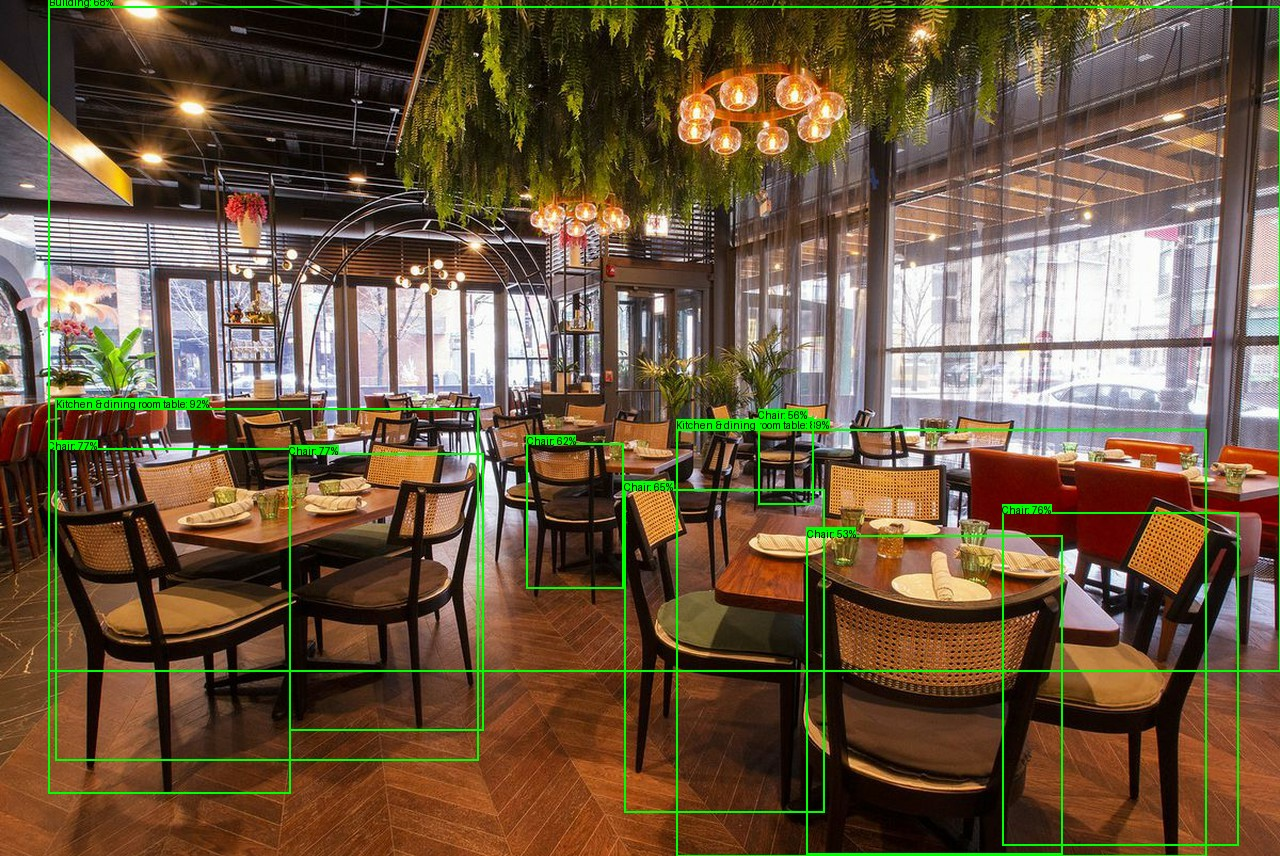

## Processing Multiple Images for Object Detection
This code demonstrates how to process multiple images for object detection using a pre-trained model from TensorFlow Hub. A list of image URLs is provided to be processed sequentially. The detect_img function handles downloading, resizing, and detecting objects in an image. It first downloads and resizes the image using the download_and_resize_image function. Then, it runs the object detector on the image with the run_detector function, which loads, processes, and displays the image with detected objects and bounding boxes. The total time taken for each image is measured and printed. The example provided processes the first image URL from the list.

In [10]:
# List of image URLs to be processed
image_urls = [
    "https://www.travelwisconsin.com/uploads/blog/e2/e2ccbd6f-1070-4272-889b-cc7720bd664d-farm-scene-with-cows.jpg",
    "https://c8.alamy.com/comp/DB00NR/busy-street-in-madurai-india-DB00NR.jpg",
    "https://img.freepik.com/free-photo/group-portrait-adorable-puppies_53876-64778.jpg",
]

def detect_img(image_url):
    # Start the timer to measure the total time for downloading, resizing, and detecting objects
    start_time = time.time()
    
    # Download and resize the image from the given URL
    image_path = download_and_resize_image(image_url, 640, 480)
    
    # Run the object detector on the downloaded image
    run_detector(detector, image_path)
    
    # Stop the timer
    end_time = time.time()
    
    # Print the total inference time
    print("Inference time:", end_time - start_time)

# Detect objects in the first image URL from the list
detect_img(image_urls[0])


Image downloaded to C:\Users\Admin\AppData\Local\Temp\tmpp9ahq1oy.jpg.
Found 100 objects.
Inference time:  3.6002535820007324
Inference time: 8.999912977218628


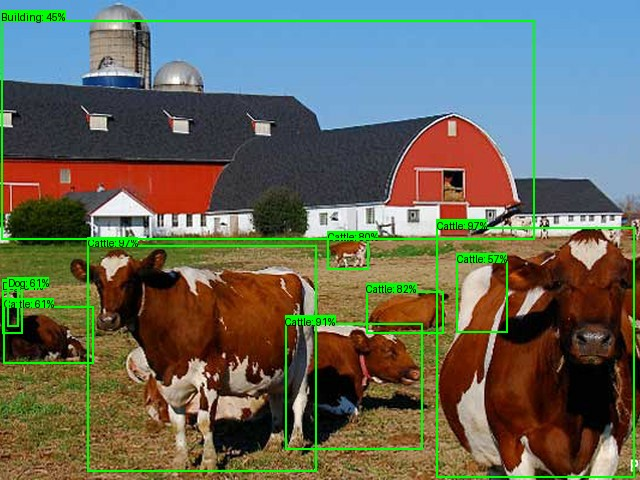